The dataset used in this project can be downloaded from [here](https://www.kaggle.com/thevirusx3/automated-essay-scoring-dataset?select=valid_set.tsv) on Kaggle

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()

import tensorflow as tf

from gensim.models import Word2Vec

from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score

import my_utils
from my_utils import essay_to_wordlist, essay_to_sentences, makeFeatureVec, getAvgFeatureVecs, get_model

In [2]:
df = pd.read_csv('./data/long.tsv', delimiter='\t', encoding='ISO-8859-1',
                      usecols=['essay_set', 'essay', 'domain1_score'])

y = df['domain1_score']
X = df['essay']

In [3]:
df.head(10)

,essay_set,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,1,"Dear @LOCATION1, I know having computers has a...",8
5,1,"Dear @LOCATION1, I think that computers have a...",8
6,1,Did you know that more and more people these d...,10
7,1,@PERCENT1 of people agree that computers make ...,10
8,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",9
9,1,In the @LOCATION1 we have the technology of a ...,9


In [4]:
X.head()

0    Dear local newspaper, I think effects computer...
1    Dear @CAPS1 @CAPS2, I believe that using compu...
2    Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...
3    Dear Local Newspaper, @CAPS1 I have found that...
4    Dear @LOCATION1, I know having computers has a...
Name: essay, dtype: object

In [5]:
y.tail()

12971    35
12972    32
12973    40
12974    40
12975    40
Name: domain1_score, dtype: int64

### 5-Fold Cross Validation Training

In [6]:
cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []

clf_model = my_utils.get_model()

for count, (traincv, testcv) in enumerate(cv.split(X)):
    print("\n--------Fold {}--------\n".format(count+1))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]

    sentences = []
    
    for essay in X_train:
            # Obtaining all sentences from the training essays.
            sentences += my_utils.essay_to_sentences(essay, remove_stopwords=True)
            
    # Initializing variables for word2vec model.
    num_features = 300
    min_word_count = 40
    num_workers = 8
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count, window=context, sample=downsampling)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in X_train:
        clean_train_essays.append(my_utils.essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = my_utils.getAvgFeatureVecs(clean_train_essays, w2v, num_features)
    
    clean_test_essays = []
    for essay_v in X_test:
        clean_test_essays.append(my_utils.essay_to_wordlist(essay_v, remove_stopwords=True))
    testDataVecs = my_utils.getAvgFeatureVecs(clean_test_essays, w2v, num_features)
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)

    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    print('Finished Word2Vec training\n')
    
    print('Training the Sequential Model...')
    clf_model.fit(trainDataVecs, y_train, batch_size=32, epochs=5)
    y_pred = clf_model.predict(testDataVecs)
    
#     Save any one of the 5 models.
#     if count + 1 == 5:
#         clf_model.save('./saved_model/aes_model.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print(f"Kappa Score: {result}")
    results.append(result)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 600)            1083600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               255744    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,339,473
Trainable params: 1,339,473
Non-trainable params: 0
_________________________________________________________________

--------Fold 1--------

Training Word2Vec Model...
Finished Word2Vec training

Training the Sequential Model...
Epoch 1/5
325/325 [==============================] - 12s 20ms/step - loss: 28.0532 - mae: 3.0787
Epoch 2/5
325/325 [===============

In [7]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=4))

Average Kappa score after a 5-fold cross validation:  0.9623


### Random Plot of Comparison (Manual Evaluated vs Model Predicted Scores)

In [19]:
def plot():
    y_test.reset_index(drop=True, inplace=True)
    indices = np.random.choice(y_test.index, size=30)
    test, pred = y_test[indices], y_pred.flatten().astype(int)[indices]
    plt.figure(figsize=(20, 5))
    plt.plot(range(30), test)
    plt.plot(range(30), pred)
    plt.xticks(range(30))
    plt.legend(['Human Score', 'Predicted Score'])
    plt.xlabel('Questions')
    plt.ylabel('Marks')
    plt.show()

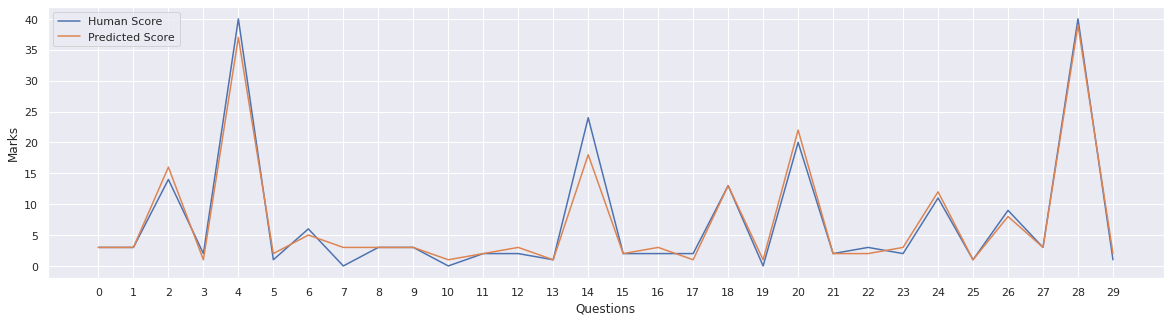

In [20]:
plot()